# BPIC 2017 Simulation Benchmark

This notebook benchmarks the simulated event log against 100 sample cases from the BPIC 2017 event log.

**Prerequisites:**
1. Run simulation first: `python integration/test_integration.py --mode advanced --num-cases 100`
2. Ensure the BPIC 2017 event log is available at `eventlog/eventlog.xes.gz`

**What this benchmark does:**
- Filters BPIC 2017 log to start/complete lifecycles only
- Samples 100 random cases
- Compares against simulated log with comprehensive metrics and visualizations


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Add project root to path
project_root = Path().resolve()
sys.path.insert(0, str(project_root))

try:
    import pm4py
    PM4PY_AVAILABLE = True
except ImportError:
    PM4PY_AVAILABLE = False
    print("ERROR: pm4py is required. Install with: pip install pm4py")

from integration.SimulationBenchmark import SimulationBenchmark
from next_activity_prediction.data_preprocessing import filter_lifecycles

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Setup complete!")


Setup complete!


## Load and Prepare Data


In [2]:
def load_bpic17_sample(log_path: str, num_cases: int = 100, seed: int = 42) -> pd.DataFrame:
    """Load BPIC 2017 event log, filter to start/complete lifecycles, and sample cases."""
    if not Path(log_path).exists():
        raise FileNotFoundError(f"Event log not found: {log_path}")
    
    print(f"Loading BPIC 2017 event log from {log_path}...")
    
    # Load event log
    if log_path.endswith('.xes') or log_path.endswith('.xes.gz'):
        log = pm4py.read_xes(log_path)
        df = pm4py.convert_to_dataframe(log)
    elif log_path.endswith('.csv') or log_path.endswith('.csv.gz'):
        df = pd.read_csv(log_path)
    else:
        raise ValueError(f"Unsupported file format: {log_path}")
    
    print(f"Loaded {len(df):,} events, {df['case:concept:name'].nunique():,} cases")
    
    # Filter to start/complete lifecycles
    print("\nFiltering to start/complete lifecycles...")
    df = filter_lifecycles(df)
    
    # Sample cases
    all_cases = df['case:concept:name'].unique()
    np.random.seed(seed)
    sampled_cases = np.random.choice(all_cases, size=min(num_cases, len(all_cases)), replace=False)
    
    df_sampled = df[df['case:concept:name'].isin(sampled_cases)].copy()
    
    print(f"Sampled {len(sampled_cases)} cases")
    print(f"Result: {len(df_sampled):,} events from {df_sampled['case:concept:name'].nunique():,} cases")
    
    return df_sampled

# Load data
bpic17_log = project_root / "eventlog" / "eventlog.xes.gz"
simulated_log = project_root / "integration" / "output" / "simulated_log.xes"

if not bpic17_log.exists():
    raise FileNotFoundError(f"BPIC 2017 event log not found: {bpic17_log}")

if not simulated_log.exists():
    raise FileNotFoundError(f"Simulated log not found: {simulated_log}\nRun simulation first!")

print("=" * 80)
print("BPIC 2017 BENCHMARK")
print("=" * 80)
print(f"Original log: {bpic17_log}")
print(f"Simulated log: {simulated_log}")
print("=" * 80)

# Load and prepare BPIC 2017 sample
bpic17_sample = load_bpic17_sample(str(bpic17_log), num_cases=100, seed=42)


BPIC 2017 BENCHMARK
Original log: D:\Repos\process-simulation-engine-1\eventlog\eventlog.xes.gz
Simulated log: D:\Repos\process-simulation-engine-1\integration\output\simulated_log.xes
Loading BPIC 2017 event log from D:\Repos\process-simulation-engine-1\eventlog\eventlog.xes.gz...
Loaded 1,202,267 events, 31,509 cases

Filtering to start/complete lifecycles...
Sampled 100 cases
Result: 1,799 events from 100 cases


## Run Benchmark


In [3]:
# Create benchmark
benchmark = SimulationBenchmark(
    bpic17_sample,  # Original: BPIC 2017 sample (DataFrame)
    str(simulated_log)  # Simulated: from file
)

# Compute all metrics
print("\nComputing benchmark metrics...")
print("This may take a few minutes...")
results = benchmark.compute_all_metrics()

print("\n✓ Benchmark computation complete!")


Loading simulated log from D:\Repos\process-simulation-engine-1\integration\output\simulated_log.xes...

Computing benchmark metrics...
This may take a few minutes...
Computing benchmark metrics...
  - Basic statistics...
  - Events per case...
  - Case throughput time...
  - Case arrivals...
  - Case completions...
  - Control flow (DFG)...
  - Trace variants...
  - Start/End activities...
  - Activity durations...
  - Overall activity distribution...
  - Simple similarity metrics...
  - Resource statistics...
Benchmark computation complete!

✓ Benchmark computation complete!


## Visualizations

### 1. Simple Similarity Metrics Overview


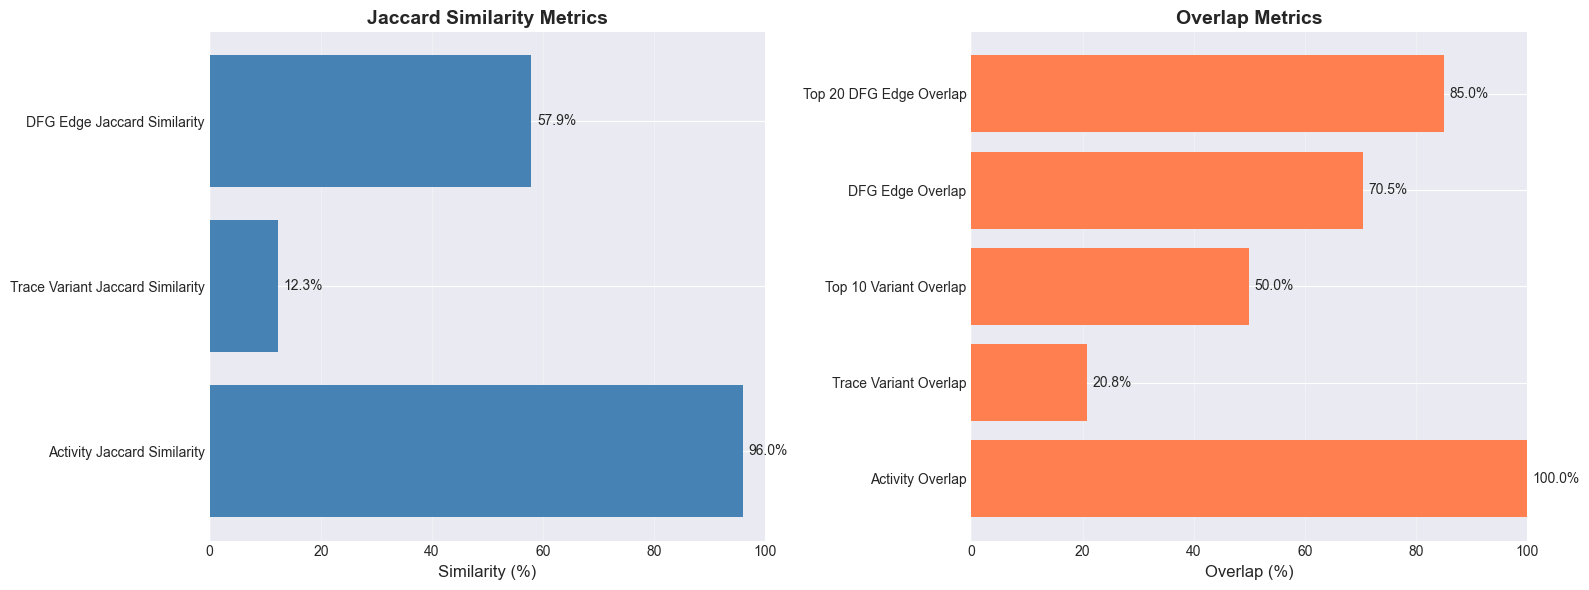


Simple Similarity Metrics:


,Metric,Value,Percentage
0,Activity Overlap,24 / 24 activities,100.000000
1,Activity Jaccard Similarity,0.9600,96.000000
2,Trace Variant Overlap,15 / 72 variants,20.833333
3,Trace Variant Jaccard Similarity,0.1230,12.295082
4,Top 10 Variant Overlap,5 / 10 variants,50.000000
5,DFG Edge Overlap,55 / 78 edges,70.512821
6,DFG Edge Jaccard Similarity,0.5789,57.894737
7,Top 20 DFG Edge Overlap,17 / 20 edges,85.000000
8,Case Count Ratio,100 / 100 cases,100.000000
9,Event Count Ratio,1616 / 1799 events,89.827682


In [4]:
# Extract similarity metrics
simple_metrics = results['simple_metrics']
similarity_metrics = simple_metrics[simple_metrics['Metric'].str.contains('Jaccard|Overlap', case=False, na=False)].copy()

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Jaccard similarities
jaccard_metrics = similarity_metrics[similarity_metrics['Metric'].str.contains('Jaccard', na=False)]
if len(jaccard_metrics) > 0:
    ax1.barh(jaccard_metrics['Metric'], jaccard_metrics['Percentage'], color='steelblue')
    ax1.set_xlabel('Similarity (%)', fontsize=12)
    ax1.set_title('Jaccard Similarity Metrics', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 100)
    ax1.grid(axis='x', alpha=0.3)
    for i, v in enumerate(jaccard_metrics['Percentage']):
        ax1.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

# Overlap percentages
overlap_metrics = similarity_metrics[similarity_metrics['Metric'].str.contains('Overlap', na=False)]
if len(overlap_metrics) > 0:
    ax2.barh(overlap_metrics['Metric'], overlap_metrics['Percentage'], color='coral')
    ax2.set_xlabel('Overlap (%)', fontsize=12)
    ax2.set_title('Overlap Metrics', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.grid(axis='x', alpha=0.3)
    for i, v in enumerate(overlap_metrics['Percentage']):
        ax2.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Display table
print("\nSimple Similarity Metrics:")
display(simple_metrics)


### 2. Overall Activity Distribution


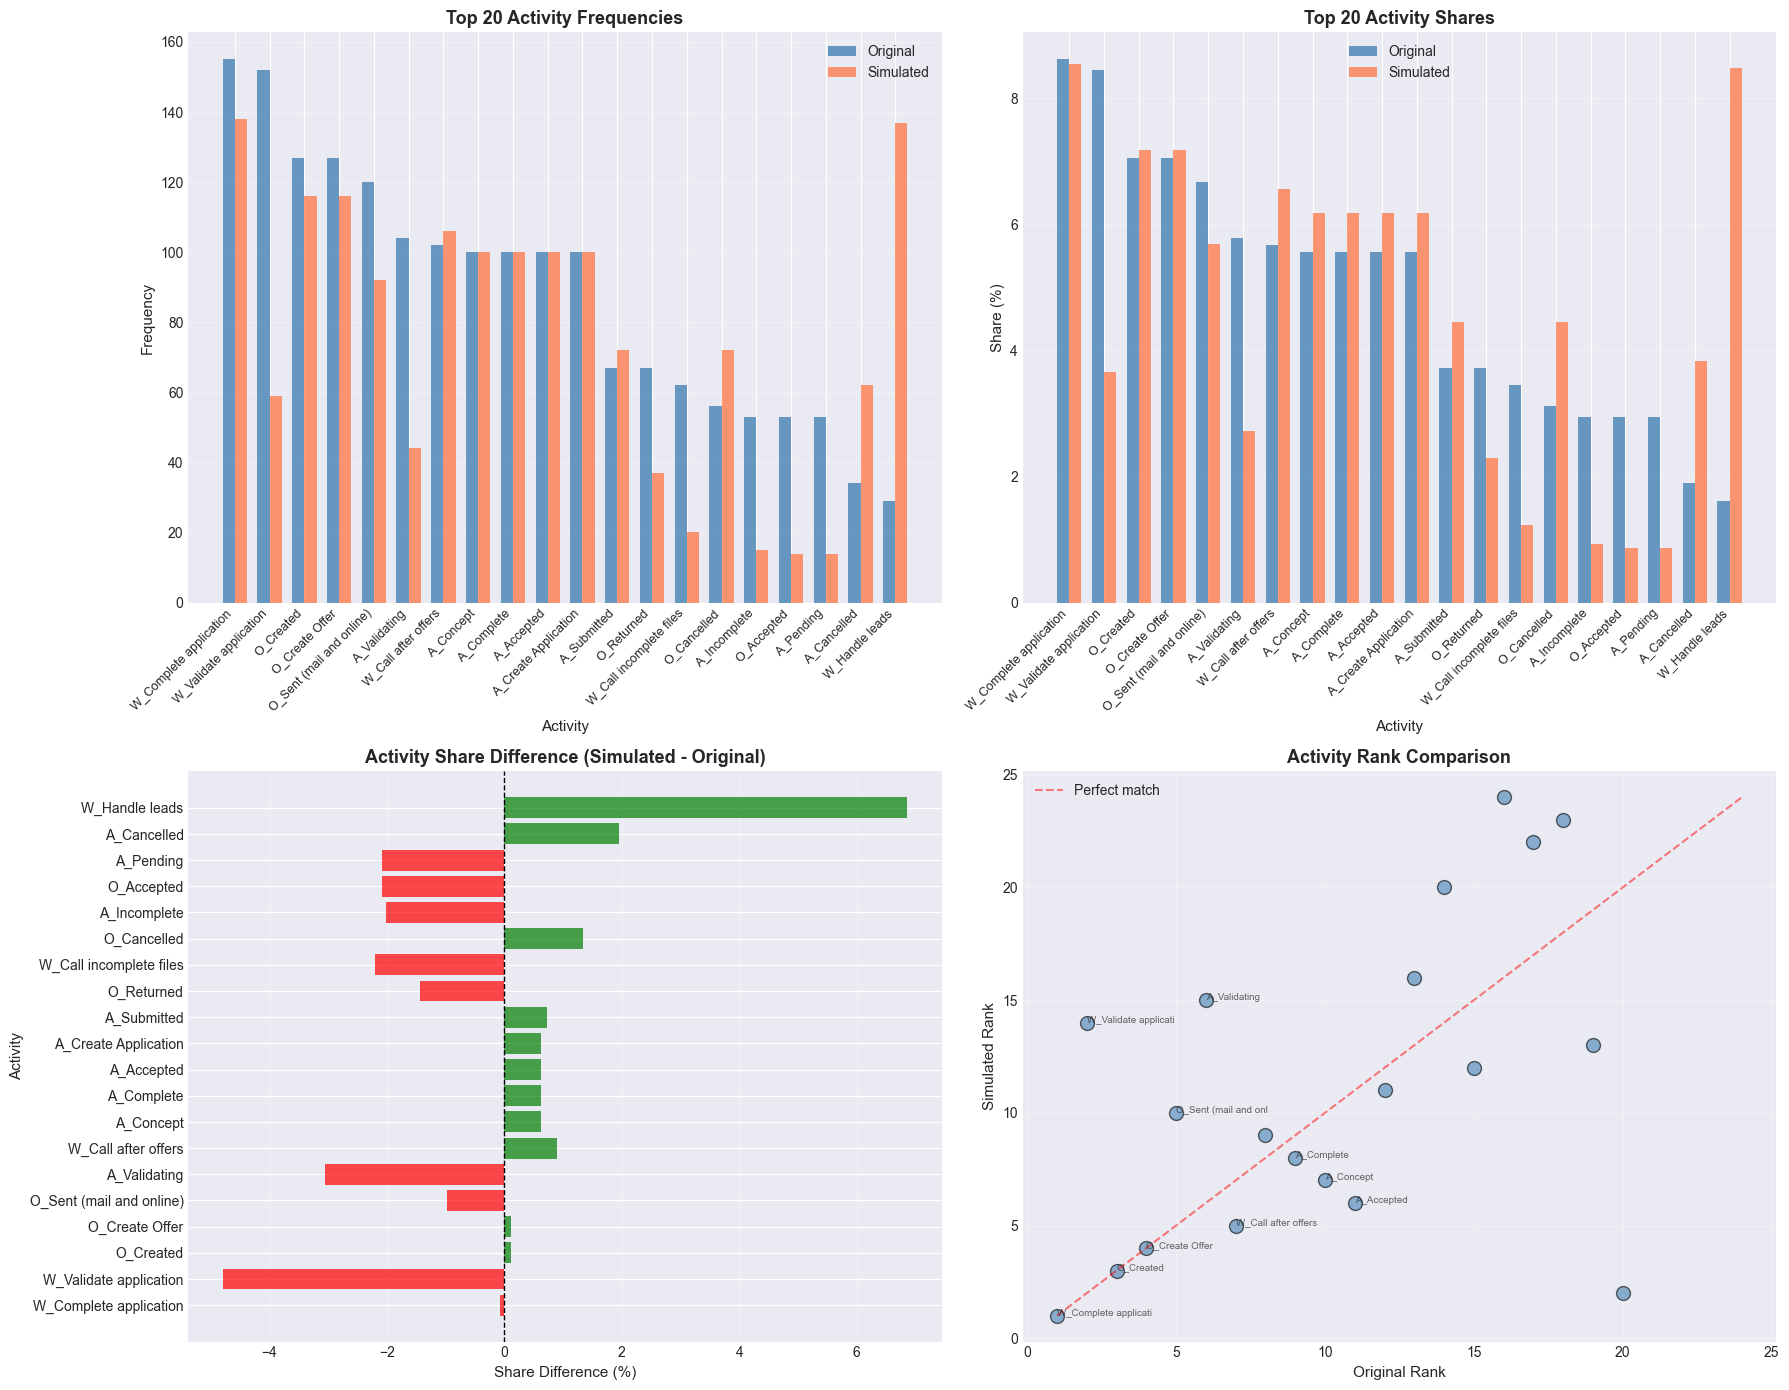


Total activities: Original=25, Simulated=25


In [5]:
# Get activity distribution
activity_dist = results['activity_distribution'].head(20)  # Top 20 activities

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Activity frequency comparison (top 20)
ax1 = axes[0, 0]
x_pos = np.arange(len(activity_dist))
width = 0.35
ax1.bar(x_pos - width/2, activity_dist['Original Count'], width, label='Original', color='steelblue', alpha=0.8)
ax1.bar(x_pos + width/2, activity_dist['Simulated Count'], width, label='Simulated', color='coral', alpha=0.8)
ax1.set_xlabel('Activity', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Top 20 Activity Frequencies', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(activity_dist['Activity'], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Activity share comparison
ax2 = axes[0, 1]
ax2.bar(x_pos - width/2, activity_dist['Original Share (%)'], width, label='Original', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, activity_dist['Simulated Share (%)'], width, label='Simulated', color='coral', alpha=0.8)
ax2.set_xlabel('Activity', fontsize=11)
ax2.set_ylabel('Share (%)', fontsize=11)
ax2.set_title('Top 20 Activity Shares', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(activity_dist['Activity'], rotation=45, ha='right', fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Share difference
ax3 = axes[1, 0]
colors = ['red' if x < 0 else 'green' for x in activity_dist['Share Difference (%)']]
ax3.barh(activity_dist['Activity'], activity_dist['Share Difference (%)'], color=colors, alpha=0.7)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Share Difference (%)', fontsize=11)
ax3.set_ylabel('Activity', fontsize=11)
ax3.set_title('Activity Share Difference (Simulated - Original)', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Rank comparison scatter
ax4 = axes[1, 1]
ax4.scatter(activity_dist['Original Rank'], activity_dist['Simulated Rank'], 
           s=100, alpha=0.6, color='steelblue', edgecolors='black', linewidth=1)
# Add diagonal line
max_rank = max(activity_dist[['Original Rank', 'Simulated Rank']].max())
ax4.plot([1, max_rank], [1, max_rank], 'r--', alpha=0.5, label='Perfect match')
ax4.set_xlabel('Original Rank', fontsize=11)
ax4.set_ylabel('Simulated Rank', fontsize=11)
ax4.set_title('Activity Rank Comparison', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)
# Add activity labels for top activities
for idx, row in activity_dist.head(10).iterrows():
    if pd.notna(row['Original Rank']) and pd.notna(row['Simulated Rank']):
        ax4.annotate(row['Activity'][:20], 
                    (row['Original Rank'], row['Simulated Rank']),
                    fontsize=7, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nTotal activities: Original={len(results['activity_distribution'])}, Simulated={len(results['activity_distribution'][results['activity_distribution']['Simulated Count'] > 0])}")


### 3. Trace Variant Distribution


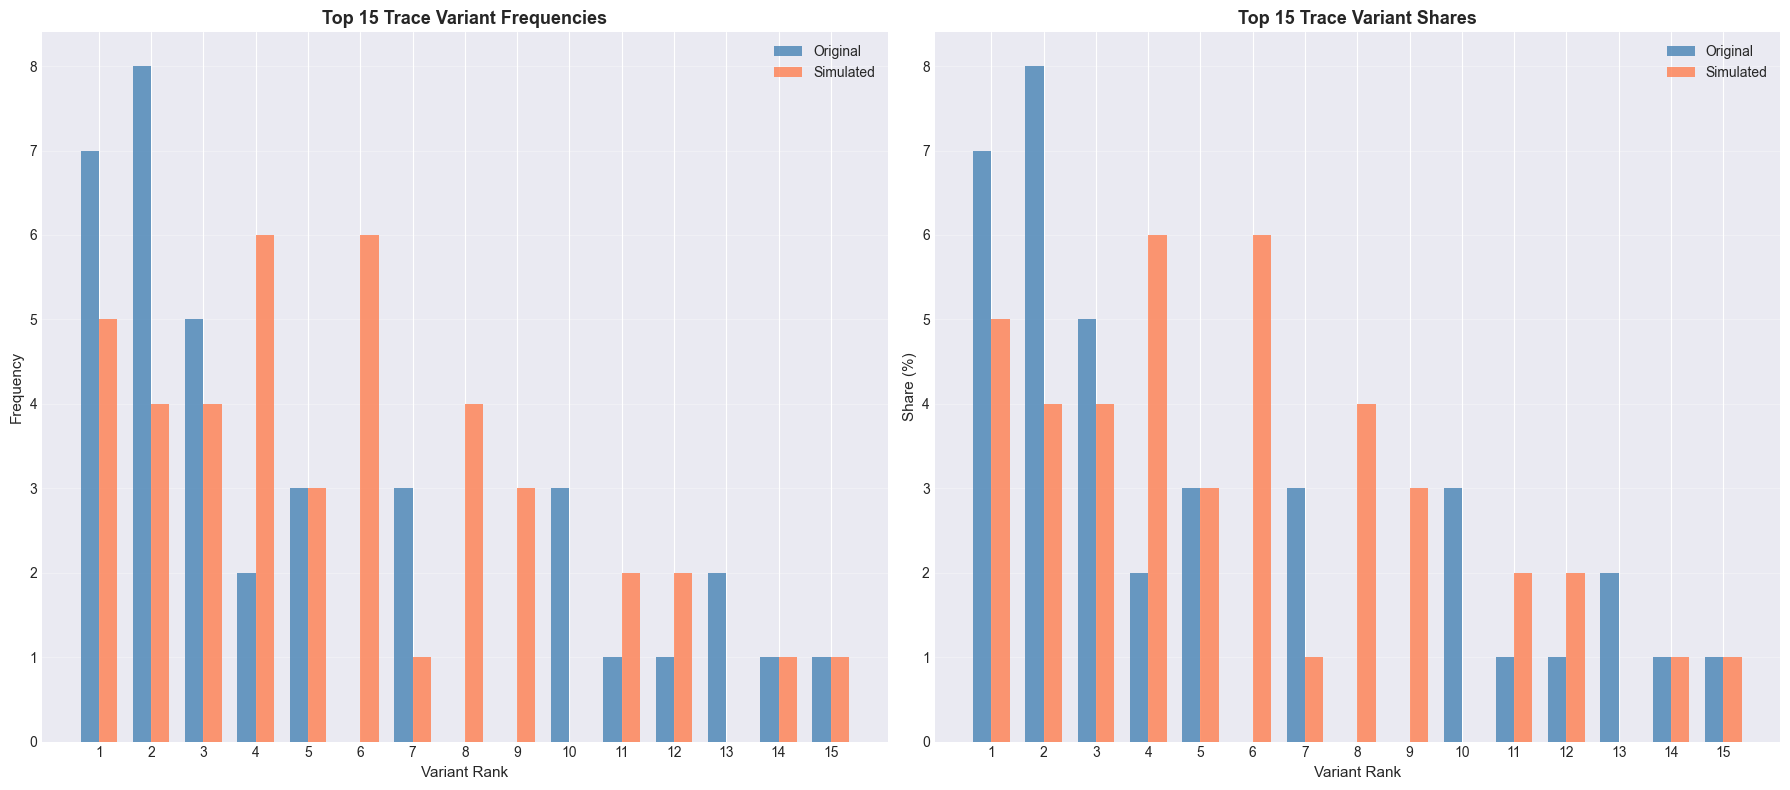


Top 10 Trace Variants:


,Variant,Original Count,Original Share (%),Simulated Count,Simulated Share (%)
21,A_Create Application → A_Submitted → A_Concept...,7,7.0,5,5.0
7,A_Create Application → A_Submitted → A_Concept...,8,8.0,4,4.0
13,A_Create Application → W_Complete application ...,5,5.0,4,4.0
23,A_Create Application → A_Submitted → W_Handle ...,2,2.0,6,6.0
3,A_Create Application → A_Submitted → W_Handle ...,3,3.0,3,3.0
22,A_Create Application → A_Submitted → A_Concept...,0,0.0,6,6.0
25,A_Create Application → A_Concept → W_Complete ...,3,3.0,1,1.0
32,A_Create Application → A_Submitted → W_Handle ...,0,0.0,4,4.0
24,A_Create Application → A_Concept → W_Complete ...,0,0.0,3,3.0
29,A_Create Application → A_Submitted → A_Concept...,3,3.0,0,0.0


In [6]:
# Get variant comparison
variants_comparison = results['variants_comparison'].head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Top variants comparison
ax1 = axes[0]
x_pos = np.arange(len(variants_comparison))
width = 0.35
ax1.bar(x_pos - width/2, variants_comparison['Original Count'], width, 
       label='Original', color='steelblue', alpha=0.8)
ax1.bar(x_pos + width/2, variants_comparison['Simulated Count'], width, 
       label='Simulated', color='coral', alpha=0.8)
ax1.set_xlabel('Variant Rank', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Top 15 Trace Variant Frequencies', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(range(1, len(variants_comparison) + 1))
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Variant share comparison
ax2 = axes[1]
ax2.bar(x_pos - width/2, variants_comparison['Original Share (%)'], width, 
       label='Original', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, variants_comparison['Simulated Share (%)'], width, 
       label='Simulated', color='coral', alpha=0.8)
ax2.set_xlabel('Variant Rank', fontsize=11)
ax2.set_ylabel('Share (%)', fontsize=11)
ax2.set_title('Top 15 Trace Variant Shares', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(range(1, len(variants_comparison) + 1))
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display top variants
print("\nTop 10 Trace Variants:")
display(variants_comparison.head(10)[['Variant', 'Original Count', 'Original Share (%)', 
                                     'Simulated Count', 'Simulated Share (%)']])


### 4. Events per Case Distribution


In [ ]:
# Extract events per case data
events_per_case = results['events_per_case']

# Calculate distributions from original data
orig_events_per_case = benchmark.original_log.groupby('case_id').size()
sim_events_per_case = benchmark.simulated_log.groupby('case_id').size()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram comparison
ax1 = axes[0]
ax1.hist(orig_events_per_case, bins=30, alpha=0.6, label='Original', color='steelblue', density=True)
ax1.hist(sim_events_per_case, bins=30, alpha=0.6, label='Simulated', color='coral', density=True)
ax1.set_xlabel('Events per Case', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Events per Case Distribution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Box plot comparison
ax2 = axes[1]
data_to_plot = [orig_events_per_case.values, sim_events_per_case.values]
bp = ax2.boxplot(data_to_plot, labels=['Original', 'Simulated'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('coral')
bp['boxes'][1].set_alpha(0.7)
ax2.set_ylabel('Events per Case', fontsize=11)
ax2.set_title('Events per Case - Box Plot', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display statistics
print("\nEvents per Case Statistics:")
display(events_per_case)


### 5. Case Throughput Time Distribution


In [ ]:
# Extract throughput time data
throughput_time = results['throughput_time']

# Calculate distributions from original data
orig_case_times = benchmark.original_log.groupby('case_id')['timestamp'].agg(['min', 'max'])
orig_throughput = (orig_case_times['max'] - orig_case_times['min']).dt.total_seconds() / 3600  # hours

sim_case_times = benchmark.simulated_log.groupby('case_id')['timestamp'].agg(['min', 'max'])
sim_throughput = (sim_case_times['max'] - sim_case_times['min']).dt.total_seconds() / 3600  # hours

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram comparison
ax1 = axes[0]
ax1.hist(orig_throughput, bins=40, alpha=0.6, label='Original', color='steelblue', density=True)
ax1.hist(sim_throughput, bins=40, alpha=0.6, label='Simulated', color='coral', density=True)
ax1.set_xlabel('Throughput Time (hours)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Case Throughput Time Distribution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_xlim(0, min(orig_throughput.quantile(0.95), sim_throughput.quantile(0.95)) * 1.1)

# 2. Box plot comparison
ax2 = axes[1]
data_to_plot = [orig_throughput.values, sim_throughput.values]
bp = ax2.boxplot(data_to_plot, labels=['Original', 'Simulated'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('coral')
bp['boxes'][1].set_alpha(0.7)
ax2.set_ylabel('Throughput Time (hours)', fontsize=11)
ax2.set_title('Case Throughput Time - Box Plot', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display statistics
print("\nThroughput Time Statistics (hours):")
display(throughput_time)


### 6. Directly-Follows Graph (DFG) Comparison


In [ ]:
# Get DFG comparison
dfg_comparison = results['dfg_comparison'].head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Top DFG edges frequency
ax1 = axes[0]
x_pos = np.arange(len(dfg_comparison))
width = 0.35
ax1.bar(x_pos - width/2, dfg_comparison['Original Count'], width, 
       label='Original', color='steelblue', alpha=0.8)
ax1.bar(x_pos + width/2, dfg_comparison['Simulated Count'], width, 
       label='Simulated', color='coral', alpha=0.8)
ax1.set_xlabel('DFG Edge Rank', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Top 20 DFG Edge Frequencies', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(range(1, len(dfg_comparison) + 1))
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. DFG edge share comparison
ax2 = axes[1]
ax2.bar(x_pos - width/2, dfg_comparison['Original Share (%)'], width, 
       label='Original', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, dfg_comparison['Simulated Share (%)'], width, 
       label='Simulated', color='coral', alpha=0.8)
ax2.set_xlabel('DFG Edge Rank', fontsize=11)
ax2.set_ylabel('Share (%)', fontsize=11)
ax2.set_title('Top 20 DFG Edge Shares', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(range(1, len(dfg_comparison) + 1))
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display top edges
print("\nTop 10 DFG Edges:")
display(dfg_comparison.head(10)[['From', 'To', 'Original Count', 'Original Share (%)', 
                                 'Simulated Count', 'Simulated Share (%)']])


### 7. Basic Statistics Summary


In [ ]:
# Basic statistics
basic_stats = results['basic_stats']

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for grouped bar chart
metrics = ['Number of Events', 'Number of Cases', 'Number of Unique Activities']
if 'Number of Unique Resources' in basic_stats.columns:
    metrics.append('Number of Unique Resources')

x = np.arange(len(metrics))
width = 0.35

orig_values = [basic_stats[basic_stats['Log'] == 'Original'][m].values[0] for m in metrics]
sim_values = [basic_stats[basic_stats['Log'] == 'Simulated'][m].values[0] for m in metrics]

ax.bar(x - width/2, orig_values, width, label='Original', color='steelblue', alpha=0.8)
ax.bar(x + width/2, sim_values, width, label='Simulated', color='coral', alpha=0.8)

ax.set_xlabel('Metric', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Basic Statistics Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (orig, sim) in enumerate(zip(orig_values, sim_values)):
    ax.text(i - width/2, orig, f'{orig:,}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, sim, f'{sim:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nBasic Statistics:")
display(basic_stats)


### 8. Start and End Activity Distributions


In [ ]:
# Start and end activities
start_activities = results['start_activities']
end_activities = results['end_activities']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Start activities
ax1 = axes[0]
top_start = start_activities.head(10)
x_pos = np.arange(len(top_start))
width = 0.35
ax1.bar(x_pos - width/2, top_start['Original Share (%)'], width, 
       label='Original', color='steelblue', alpha=0.8)
ax1.bar(x_pos + width/2, top_start['Simulated Share (%)'], width, 
       label='Simulated', color='coral', alpha=0.8)
ax1.set_xlabel('Activity', fontsize=11)
ax1.set_ylabel('Share (%)', fontsize=11)
ax1.set_title('Top 10 Start Activities', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(top_start['Activity'], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# End activities
ax2 = axes[1]
top_end = end_activities.head(10)
x_pos = np.arange(len(top_end))
ax2.bar(x_pos - width/2, top_end['Original Share (%)'], width, 
       label='Original', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, top_end['Simulated Share (%)'], width, 
       label='Simulated', color='coral', alpha=0.8)
ax2.set_xlabel('Activity', fontsize=11)
ax2.set_ylabel('Share (%)', fontsize=11)
ax2.set_title('Top 10 End Activities', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(top_end['Activity'], rotation=45, ha='right', fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Export Results


In [ ]:
# Export results to Excel
output_path = project_root / "integration" / "output" / "bpic17_benchmark_results.xlsx"
print(f"Exporting results to: {output_path}")
benchmark.export_results(str(output_path))
print("✓ Export complete!")

# Print summary
print("\n" + "=" * 80)
print("BENCHMARK SUMMARY")
print("=" * 80)
benchmark.print_summary()
